# WiDS 2023 - Codeup Submission
## Predict the arithmetic mean of the max and min observed temperature over the next 14 days for specific locations and start dates

## Project Description
Extreme weather events are sweeping the globe and range from heat waves, wildfires and drought to hurricanes, extreme rainfall and flooding. These weather events have multiple impacts on agriculture, energy, transportation, as well as low resource communities and disaster planning in countries across the globe.

Accurate long-term forecasts of temperature and precipitation are crucial to help people prepare and adapt to these extreme weather events. Currently, purely physics-based models dominate short-term weather forecasting. But these models have a limited forecast horizon. The availability of meteorological data offers an opportunity for data scientists to improve sub-seasonal forecasts by blending physics-based forecasts with machine learning. Sub-seasonal forecasts for weather and climate conditions (lead-times ranging from 15 to more than 45 days) would help communities and industries adapt to the challenges brought on by climate change.

Participants will submit forecasts of temperature and precipitation for one year, competing against the other teams as well as official forecasts from NOAA.

## Project Goals
* Determine which columns to use for our data exploration.
* Explore to find features that indicate the ```contest-tmp2m-14d__tmp2m```.
* Based on the findings predict the ```contest-tmp2m-14d__tmp2m``` for the test_data.
* Submit our finidings to the WiDS 2023 competition.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pre
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle1 as w
import explore1 as e
import model as m

# Acquire

* Data acquired from [Kaggle](https://www.kaggle.com/competitions/widsdatathon2023/data)
* It contained 375734 rows and 245 columns before cleaning
* Each row represents a specific location on a specific start date
* Each column represents a weather/climate measurement

# Prepare

**Prepare Actions:**
* Binned regions (Dry, Temperate, Continental) 
* Binned elevation ('bottom_low', 'top_low', 'mid', 'high')
* Split data into train, validate and test (approx. 60/25/15)
* Scaled continuous variables (min/max scaler)
* Outliers have not been removed for this iteration of the project

## Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**????**| ?????? | *string*|
|**?????**| ????? | *float*|
|**Target variable**
|**mean_temp**| the arithmetic mean of the max and min observed temperature over the next 14 days | *float* |


In [2]:
# prepping data
df = w.get_contest_data(df)

# splitting data into train, validate, and test
train, validate, test = w.split_data(df)

## A brief look at the data

In [3]:
train.head()

,region,elevation,lat,lon,startdate,potential_evap,precip,barometric_pressure,all_atmos_precip,relative_humidity,...,height_10_mb,height_100_mb,height_500_mb,height_850_mb,zonal_wind_250mb,zonal_wind_925mb,long_wind_250mb,long_wind_925mb,elevation_range,region_bins
43062,BSh,1000.0,0.227273,0.433333,2016-06-26,510.23,40.14,90770.49,29.03,32.62,...,31377.44,16707.77,5928.46,1536.71,11.31,1.87,6.97,0.25,mid,NaN
310068,Csb,1000.0,0.772727,0.066667,2015-01-03,48.25,23.02,92339.65,10.83,87.90,...,30451.45,16246.90,5710.38,1531.84,17.52,-0.25,-5.08,3.51,mid,Temperate
279304,BSk,2000.0,0.681818,0.533333,2014-11-02,147.99,7.79,78176.80,5.80,68.56,...,30778.83,16256.68,5633.01,1512.84,28.71,2.07,-12.16,0.47,high,Dry
210366,Dfc,3100.0,0.545455,0.566667,2016-03-23,54.39,22.12,75484.33,5.29,76.14,...,30744.32,16199.63,5612.65,1478.02,17.52,1.71,-2.98,-0.82,high,Continental
90381,BSk,1500.0,0.318182,0.633333,2015-12-13,203.14,5.63,84225.98,6.59,62.36,...,30760.83,16276.61,5605.47,1445.74,37.08,4.18,9.06,0.61,mid,Dry


In [30]:
df.shape

(427635, 22)

In [29]:
train.shape

(277962, 22)

# Explore

In [27]:
import explore1 as e
from importlib import reload

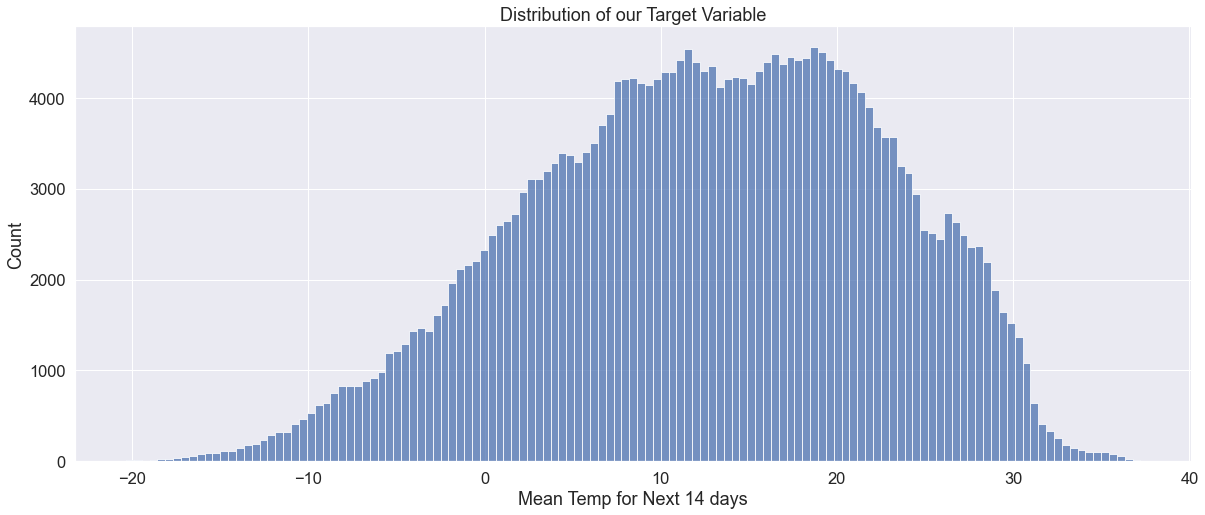

In [28]:
e.data_distribution(train)

## Is there a difference in the temperatures in different climateregions?

NameError: name 'train' is not defined

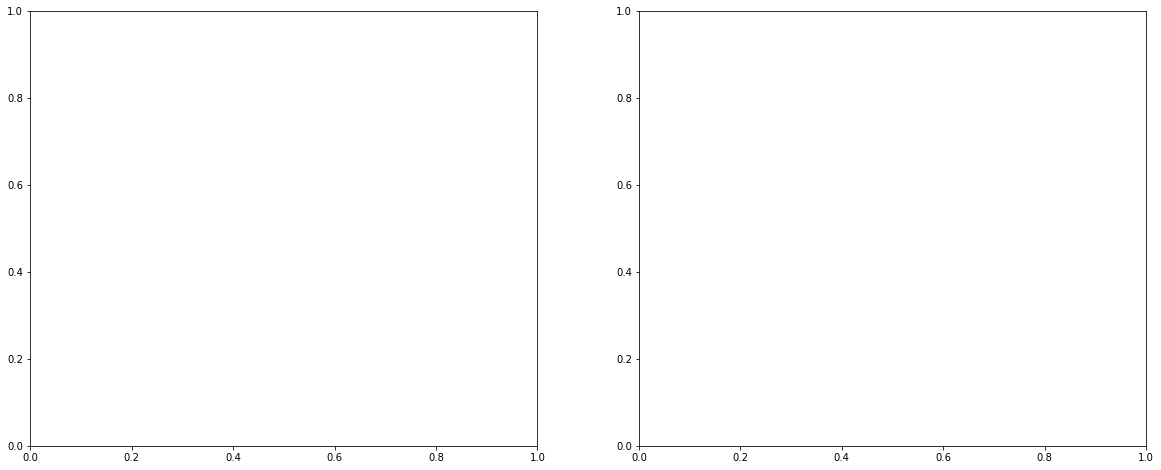

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.countplot(x='region_bins', data=train, ax=ax[0])
ax[0].title('Distribution of Regions')

sns.barplot(x='region_bins', y='mean_temp', data=train, ax=ax[1])
rate = df['mean_temp'].mean()
ax[1].title('Is there a difference between the 3 major regions and the mean temperature?')

ax[1].axhline(rate,  label = f'Average Temp Across All Regions {rate:.2f}', linestyle='dotted', color='black')
ax[1].legend()
plt.show()

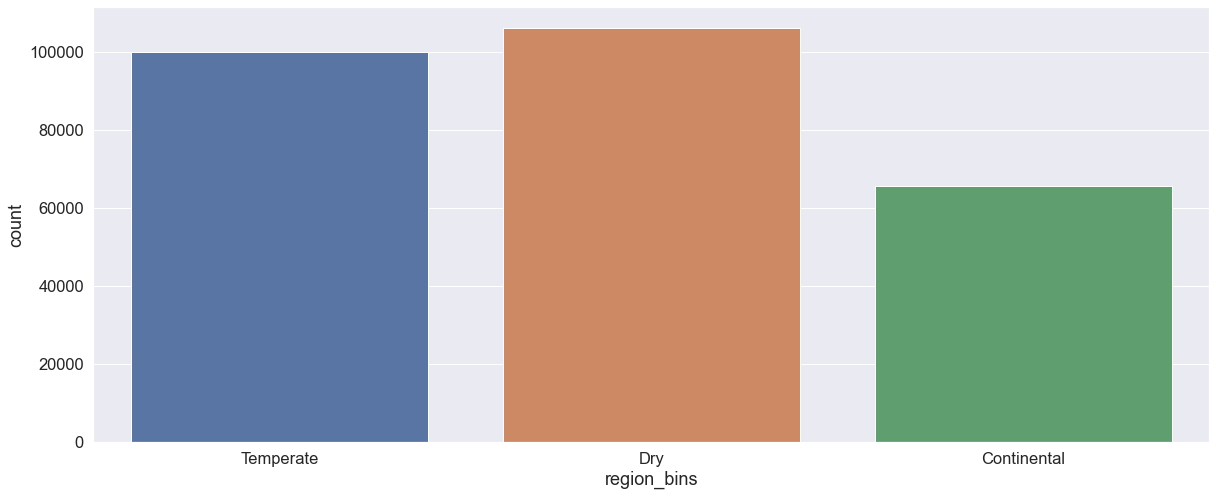

In [5]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='region_bins', data=train)
plt.show()

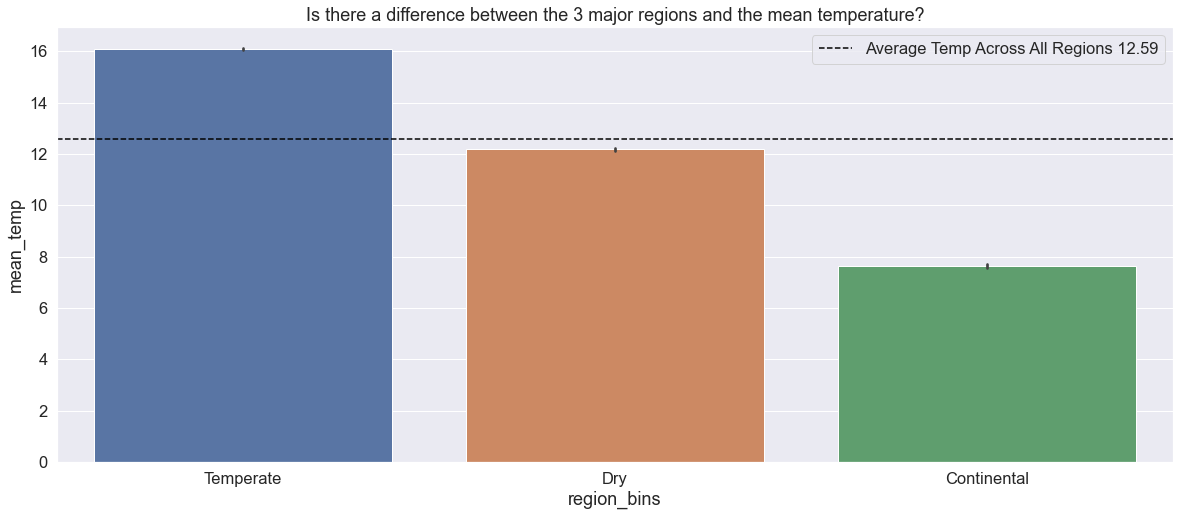

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x='region_bins', y='mean_temp', data=train)
rate = df['mean_temp'].mean()
plt.axhline(rate, label = f'Average Temp Across All Regions {rate:.2f}', linestyle='--', color='black')
plt.title('Is there a difference between the 3 major regions and the mean temperature?')
plt.legend()
plt.show()

We should bin these based on first letter of region and run Kruskall-Wallis.

In [7]:
B = train[train.region_bins == 'Dry']
C = train[train.region_bins == 'Temperate']
D = train[train.region_bins == 'Continental']

In [8]:
stats.kruskal(B.mean_temp, C.mean_temp, D.mean_temp)

KruskalResult(statistic=25428.11452488514, pvalue=0.0)

## Does elevation impact temperature?

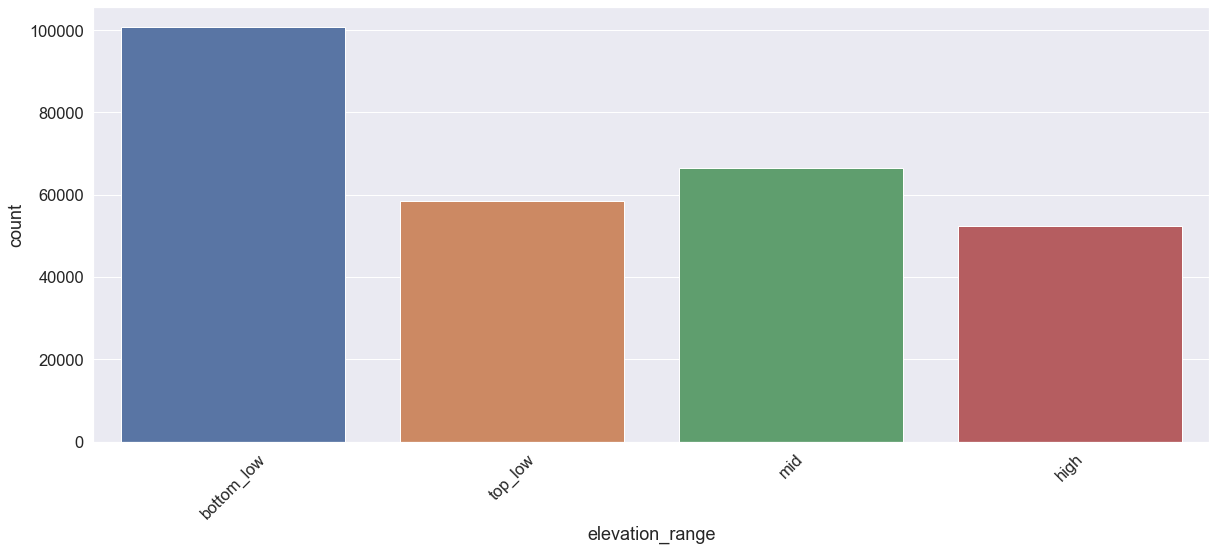

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='elevation_range', data=train)
plt.xticks(rotation = 45)
plt.show()

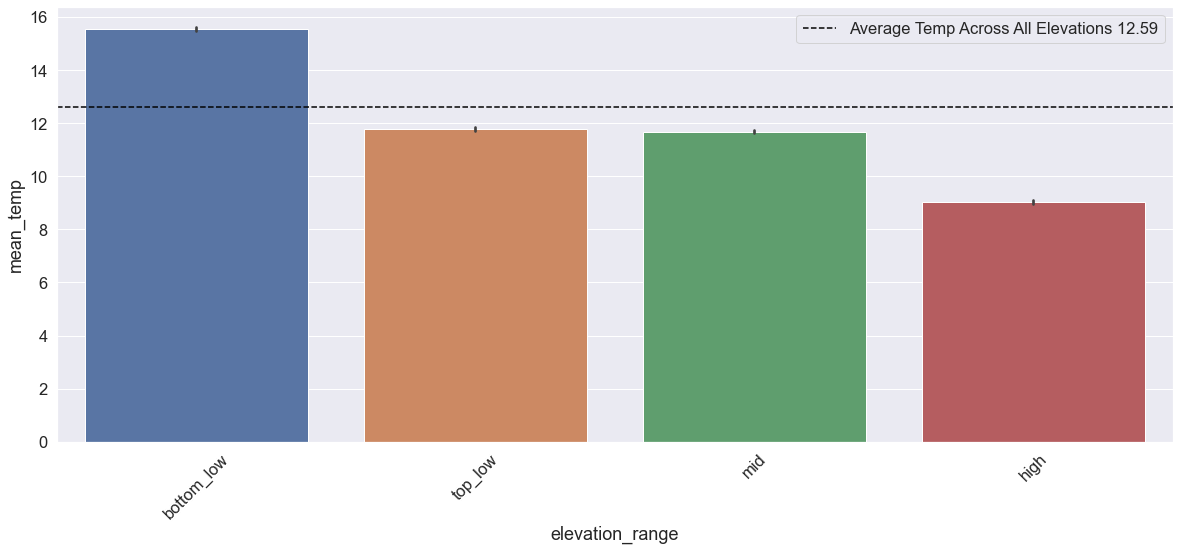

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x='elevation_range', y='mean_temp', data=train)
rate = df['mean_temp'].mean()
plt.axhline(rate, label = f'Average Temp Across All Elevations {rate:.2f}', linestyle='--', color='black')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [11]:
bl = train[train.elevation_range == 'bottom_low']
tl = train[train.elevation_range == 'top_low']
mid = train[train.elevation_range == 'mid']
h = train[train.elevation_range == 'high']

In [13]:
stats.kruskal(bl.mean_temp, tl.mean_temp, mid.mean_temp, h.mean_temp)

KruskalResult(statistic=17282.39039601857, pvalue=0.0)

## Is there a correlation between precipitation and mean_temp?

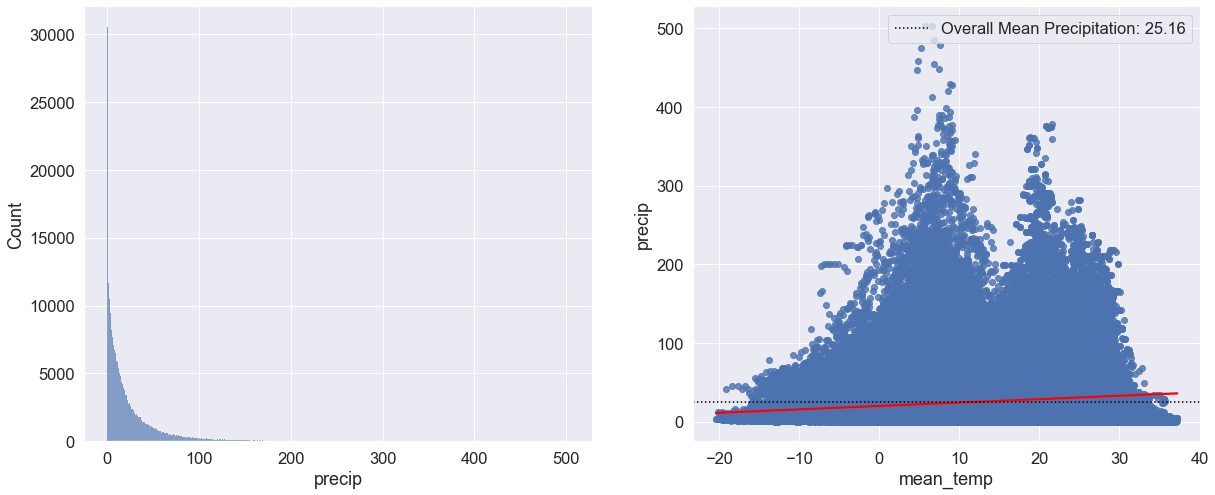

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=train, x ='precip', ax=ax[0])

sns.regplot(x='mean_temp', y='precip', data=train, line_kws={'color': 'red'}, ax=ax[1])
rate = train['precip'].mean()
ax[1].axhline(rate,  label = f'Overall Mean Precipitation: {rate:.2f}', linestyle='dotted', color='black')
ax[1].legend()
plt.show()

In [15]:
corr, p = stats.spearmanr(train['precip'], train['mean_temp'])
print(f'p-value: {p}')

p-value: 0.0


Distribution is skewed. We will not put this in our model.

## Is there a correlation between potential evap and mean_temp?

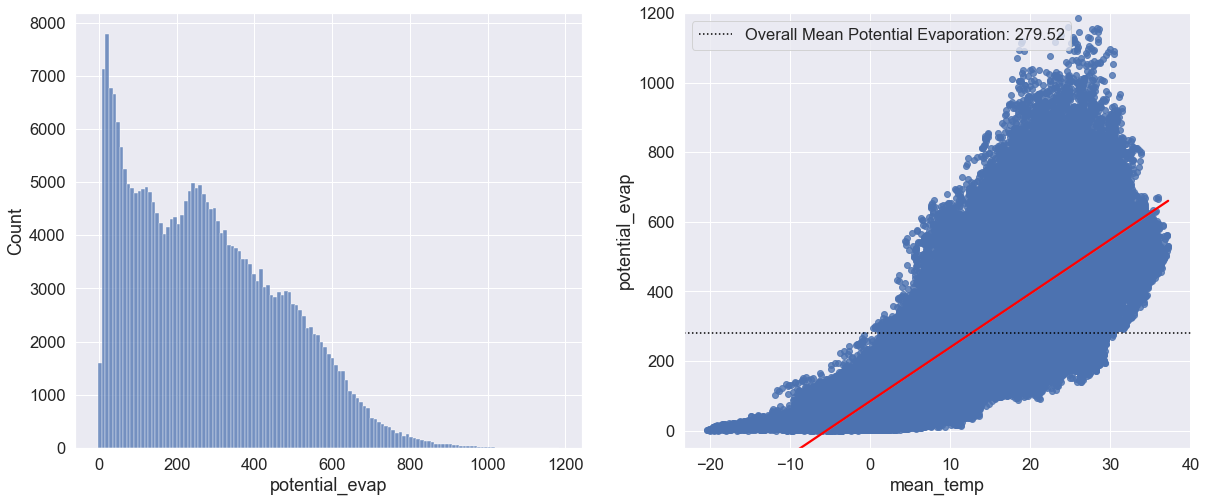

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=train, x ='potential_evap', ax=ax[0])

sns.regplot(x='mean_temp', y='potential_evap', data=train, line_kws={'color': 'red'}, ax=ax[1])
rate = train['potential_evap'].mean()
ax[1].axhline(rate,  label = f'Overall Mean Potential Evaporation: {rate:.2f}', linestyle='dotted', color='black')
ax[1].legend()
ax[1].set_ylim(-50,1200)
plt.show()

In [17]:
corr, p = stats.spearmanr(train['potential_evap'], train['mean_temp'])
print(f'p-value: {p}')

p-value: 0.0


There is a linear correlation so we will take this to the model.

# Exploration Summary

* ?????

# Features I am moving to modeling With
| Feature | Reason | 
|:--------|:-----------|
|**????**| $t-test$ results|
|**???**| $chi^2$ test results|
|**????**| $chi^2$ test results|


# Features I'm not moving to modeling with
| Feature | Reason | 
|:--------|:-----------|
|**?????**| >>>>>|
|**?????**| >>>>>|
|**?????**| >>>>>|
|**?????**| >>>>>|

In [18]:
drivers = list(train.columns)

In [19]:
drivers.remove('startdate')
drivers.remove('mean_temp')

In [20]:
#drivers.remove('region')

In [21]:
#drivers.remove('elevation')

# Modeling
* 

In [22]:
# prep data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, 'mean_temp', drivers)

In [23]:
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,9.934269,9.908398,0.025871
1,median_baseline,9.945212,9.919699,0.025513


In [24]:
X_train

,elevation,lat,lon,potential_evap,precip,barometric_pressure,all_atmos_precip,relative_humidity,sea_level_press,height_10_mb,...,region_Dfc,region_Dsb,region_Dsc,region_Dwa,region_Dwb,elevation_range_top_low,elevation_range_mid,elevation_range_high,region_bins_Dry,region_bins_Temperate
43062,0.322581,0.227273,0.433333,0.431631,0.079860,0.568834,0.527233,0.227642,0.295685,0.771242,...,0,0,0,0,0,0,1,0,0,0
310068,0.322581,0.772727,0.066667,0.042579,0.045799,0.624864,0.162795,0.878991,0.693780,0.273151,...,0,0,0,0,0,0,1,0,0,1
279304,0.645161,0.681818,0.533333,0.126574,0.015498,0.119150,0.062074,0.651113,0.658688,0.449249,...,0,0,0,0,0,0,0,1,1,0
210366,1.000000,0.545455,0.566667,0.047749,0.044009,0.023009,0.051862,0.740427,0.443771,0.430686,...,1,0,0,0,0,0,0,1,0,0
90381,0.483871,0.318182,0.633333,0.173018,0.011201,0.335148,0.077893,0.578061,0.307842,0.439567,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44808,0.548387,0.227273,0.533333,0.434469,0.003462,0.329018,0.123748,0.187934,0.298974,0.501356,...,0,0,0,0,0,0,1,0,1,0
340479,0.516129,0.818182,0.500000,0.050200,0.049400,0.254737,0.069684,0.828090,0.498216,0.373690,...,0,0,0,0,0,0,1,0,1,0
367456,0.161290,0.863636,0.833333,0.008960,0.002487,0.758664,0.054065,0.831978,0.589484,0.400031,...,0,0,0,0,0,0,0,0,0,0
255567,0.612903,0.636364,0.400000,0.031252,0.015319,0.253669,0.038246,0.696595,0.720710,0.443305,...,0,0,0,0,0,0,0,1,0,0


# Comparing Models

* ????

In [25]:
m.regression_models(X_train, y_train, X_validate, y_validate)

,model,RMSE_train,RMSE_validate
0,OLS Regressor,1.777959,1.768161
1,Lasso_alpha_1,9.934269,9.908398
2,Quadratic,1.225091,1.221786


## Best Model on Test

In [26]:
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate,RMSE_test,r^2_test
0,Quadratic,1.225091,0.984792,1.221786,0.984795,1.225424,0.984941


### Modeling Summary

* ?????

# Conclusions

### Exploration

* ????

### Modeling

* ????

### Recommendations

* ?????

### Next Steps
* ?????